## Sample scripts for full routines from sourced scripts and sourced schedules



In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import glob
import shutil
import numpy as np
import random
import sys
sys.path.append('..')
sys.path.append('../simulation')

from evolving_graph.scripts import Script
import evolving_graph.utils as utils
from evolving_graph.execution import ScriptExecutor
from evolving_graph.environment import EnvironmentGraph

from GraphReader import GraphReader, init_graph_file, scene_num
from ProgramExecutor import read_program
from ScheduleSampler import ScheduleSampler

random.seed(123)

/home/maithili/repos/tasksim/.venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def time_mins(mins, hrs, day=0):
    return (((day)*24)+hrs)*60+mins

def time_human(time_mins):
    mins = time_mins%60
    time_mins = time_mins//60
    hrs = time_mins%24
    time_mins = time_mins//24
    days = time_mins
    h = '{:02d}:{:02d}'.format(hrs,mins)
    if days != 0:
        h = str(days)+'day - '+h
    return h

def day_num(day_of_week):
    return {'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}[day_of_week]

In [3]:
init_graph = GraphReader(graph_file=init_graph_file)
print(f'Using scene {int(scene_num)-1}, i.e. \'TestScene{scene_num}\'')

Using scene 1, i.e. 'TestScene2'


In [4]:
info = {}
info['dt'] = 10   # minutes
info['num_train_routines'] = 50
info['num_test_routines'] = 5
info['weekend_days'] = []   #[day_num(day) for day in ['Saturday','Sunday']]
info['start_time'] = time_mins(mins=0, hrs=6)
info['end_time'] = time_mins(mins=0, hrs=24)
info['interleaving'] = False
info['only_used_objects'] = True
info['graphs_dt_apart'] = False


info['max_activities_per_day'] = 7

info['breakfast_only'] = True
info['single_script_only'] = False

ignore_classes = ['floor','wall','ceiling','character']
utilized_object_ids = set()
scripts_used = {('_'.join(path.split('/')[-2:]))[:-4]:0 for path in glob.glob('data/sourcedScriptsByActivity/*/*.txt')}
edge_classes = ["INSIDE", "ON"]

class SamplingFailure(Exception):
    pass

In [10]:
class Activity():
    def __init__(self, name, time_start_mins, time_end_mins=None, script_file=None, verbose=False, stack_actions=True):
        self.name = name
        directory = os.path.join('data/sourcedScriptsByActivity', name)
        if script_file is None:
            try:
                if info['single_script_only']:
                    script_files = os.listdir(directory)
                    script_files.sort()
                    script_file = script_files[0]
                else:
                    script_file = np.random.choice(os.listdir(directory))
            except:
                raise SamplingFailure(f'No script found for {name}')
            if verbose:
                print(f'Picking script {script_file} for {name}')
            headers, self.scripts, self.obj_use, _ = read_program(os.path.join(directory,script_file), init_graph.node_map)
        self.source = '_'.join([name, script_file[:-4]])
        def sample_duration(header):
            durations = (header).split('-')
            assert len(durations)==2, f"Invalid time range {header} in {name}->{script_file}"
            duration_min = int(durations[0].strip())
            duration_max = int(durations[1].strip())
            duration_sampled = (random.random() * (duration_max-duration_min) + duration_min)
            return duration_sampled
        self.durations = [int(round(sample_duration(header))) for header in headers]
        def valid_times(times):
            for time, next_time, duration in zip(times[:-1], times[1:], self.durations[:-1]):
                if next_time - time <= duration:
                    return False
                if info['graphs_dt_apart'] and next_time - time <= info['dt']:
                    return False
            return True
        if stack_actions:
            times = [time_start_mins]
            if time_end_mins is not None:
                if time_start_mins >= time_end_mins - sum(self.durations):
                    raise SamplingFailure(f'Cannot sample {sum(self.durations)}mins long activity {self.source} within {time_start_mins} and {time_end_mins}')
                times[0] = random.randrange(time_start_mins, time_end_mins - sum(self.durations))
            for d in self.durations:
                times.append(times[-1]+d)
        else:
            assert time_end is not None, 'You need to either stack actions or provide an end time.'
            for _ in range(5):
                times = (np.random.rand(len(headers)) * (time_end_mins-time_start_mins) + time_start_mins).round().astype(int)
                times.sort()
                if valid_times(times):
                    break
            if not valid_times(times):
                raise SamplingFailure(f'Invalid times {times} and durations {self.durations} for activity {self.source}')
        self.times = times
    
    def get_action_info(self):
        detailed_actions = []
        for t,d,scr,obj_s,obj_e in zip(self.times, self.durations, self.scripts, self.obj_use['start'], self.obj_use['end']):
            t2 = t+d
            detailed_actions.append({'time_from':t, 'time_to':t2, 'name':self.source, 'script':scr, 'time_from_h':time_human(t), 'time_to_h':time_human(t2), 'start_using':obj_s, 'end_using':obj_e, 'length':len(scr)})
        return detailed_actions
    
    def get_end_time(self):
        return self.times[-1] + self.durations[-1]

class Schedule():
    def __init__(self, type=None):
        pass

    def get_combined_script(self, verbose=False):
        all_actions = []
        for act in self.activities:
            all_actions += act.get_action_info()
        all_actions.sort(key = lambda x : x['time_from'])
        if verbose:
            for a in all_actions:
                print (a['time_from_h']+' to '+a['time_to_h']+' : '+a['name'])
                print ('Started using : '+str(a['start_using'])+'; Finished using : '+str(a['end_using']))
                for l in a['script']:
                    print(' - ',l)
        for end_time, next_start in zip([a['time_to'] for a in all_actions[:-1]], [a['time_from'] for a in all_actions[1:]]):
            if end_time > next_start:
                raise SamplingFailure(f'Timing conflict : End time {end_time} of an action , exceeds start time {next_start} of next action')
        return all_actions

class ScheduleFromFile(Schedule):
    def __init__(self, type=None):
        assert type == None or type in ['weekday','weekend']
        schedule_options = []
        if info['breakfast_only']: 
            self.schedule_file_path = 'data/sourcedSchedules/breakfast/dummy.json' 
        else:
            for (root,_,files) in os.walk('data/sourcedSchedules'):
                if type is not None and type not in root:
                    continue
                schedule_options += [os.path.join(root,f) for f in files]
            self.schedule_file_path = np.random.choice(schedule_options)
        with open(self.schedule_file_path) as f:
            schedule = json.load(f)
        
        def sample_act_time(act_time_options):
            tr = act_time_options[random.randrange(len(act_time_options))]
            return [[tr[0],0],[tr[1],0]]
        
        activity_with_sampled_time = [(act_name, sample_act_time(act_time_options)) for act_name,act_time_options in schedule.items()]
        time_start_mins = time_mins(act_time[0][1], act_time[0][0])
        time_end_mins = time_mins(act_time[1][1], act_time[1][0])
        self.activities = [Activity(act_name, time_start_mins=time_start_mins, time_end_mins=time_end_mins, stack_actions = not info['interleaving']) for act_name,act_time in activity_with_sampled_time]
        random.shuffle(self.activities)
        num_activities = min(info['max_activities_per_day'], len(self.activities))
        self.activities = self.activities[:num_activities]
    
class ScheduleFromHistogram(Schedule):
    def __init__(self, type=None):
        sampler = ScheduleSampler(filter_num=3, idle_sampling_factor=1.2)
        if info['breakfast_only']:
            t = sampler.sample_time_for('breakfast')
            self.activities = [Activity('breakfast', time_start_mins=t, stack_actions=True)]
        else:
            first_activity = "getting_out_of_bed"
            first_activity_done = False
            last_activity = "sleeping"
            self.activities = []
            t = info['start_time']
            while t < info['end_time']:
                activity_name = sampler(t, remove=True)
                if activity_name is None:
                    t += info['dt']
                    continue
                if not first_activity_done:
                    if activity_name != first_activity:
                        t += info['dt']
                        continue
                    else:
                        first_activity_done = True
                new_activity = Activity(activity_name, time_start_mins=t, stack_actions=True)
                self.activities.append(new_activity)
                t = new_activity.get_end_time() + 1
                if activity_name == last_activity:
                    return
            if not first_activity_done:
                raise SamplingFailure('Histogram sampler could not sample {first_activity}')
            raise SamplingFailure('Histogram sampler could not sample {last_activity}')

def get_graphs(all_actions, verbose=False):
    with open (init_graph_file,'r') as f:
        init_graph_dict = json.load(f)
    name_equivalence = utils.load_name_equivalence()
    graphs = [EnvironmentGraph(init_graph_dict).to_dict()]
    objects_in_use = [[]]
    current_objects = []
    complete_script_lines = []
    save_graph = []
    for action in all_actions:
        if verbose:
            print('## Executing '+action['name']+' from '+action['time_from_h']+' to '+action['time_to_h'])
            print ('Started using : '+str(action['start_using'])+'; Finished using : '+str(action['end_using']))
            for l in action['script']:
                print (l)
        ## add to the script
        complete_script_lines += action['script']
        save_graph.append(len(complete_script_lines))
        ## update the list of objects currently in use
        for obj in action['start_using']:
            current_objects.append(obj)
        try:
            for obj in action['end_using']:
                current_objects.remove(obj)
        except ValueError as e:
            raise ValueError('Failed to execute '+str(action['name'])+' ill-defined usage tags for '+str(obj))
        ## save the iteration results
        objects_in_use.append([{'id':o[0], 'name':o[1]} for o in current_objects])
        if verbose:
            print_graph_difference(graphs[-2],graphs[-1])
            print('Currently using : ',current_objects)
            input('Press something...')

    executor = ScriptExecutor(EnvironmentGraph(graphs[-1]), name_equivalence)
    success, state, graph_list = executor.execute(Script(complete_script_lines), w_graph_list=True)
    if not success:
        raise SamplingFailure('Execution of {} starting at {} failed because {}'.format(action['name'], action['time_from_h'], executor.info.get_error_string()))
    for idx in save_graph:
        graphs.append(graph_list[idx])
        update_used_objects(graphs[-2],graphs[-1])

    return graphs, objects_in_use



In [11]:
def remove_ignored_classes(graphs):
    clipped_graphs = []
    for graph in graphs:
        clipped_graphs.append({'nodes':[],'edges':[]})
        ignore_ids = []
        for node in graph['nodes']:
            if node['class_name'] in ignore_classes:
                ignore_ids.append(node['id'])
            elif info['only_used_objects'] and node['id'] not in utilized_object_ids:
                ignore_ids.append(node['id'])
            else:
                clipped_graphs[-1]['nodes'].append(node)
        for edge in graph['edges']:
            if edge['from_id'] in ignore_ids or edge['to_id'] in ignore_ids:
                continue
            clipped_graphs[-1]['edges'].append(edge)
    return clipped_graphs

def class_from_id(graph, id):
    lis = [n['class_name'] for n in graph['nodes'] if n['id']==id]
    if len(lis) > 0:
        return lis[0]
    else:
        return 'None'

def print_graph_difference(g1,g2):
    edges_removed = [e for e in g1['edges'] if e not in g2['edges']]
    edges_added = [e for e in g2['edges'] if e not in g1['edges']]
    nodes_removed = [n for n in g1['nodes'] if n['id'] not in [n2['id'] for n2 in g2['nodes']]]
    nodes_added = [n for n in g2['nodes'] if n['id'] not in [n2['id'] for n2 in g1['nodes']]]

    for n in nodes_removed:
        print ('Removed node : ',n)
    for n in nodes_added:
        print ('Added node   : ',n)
    for e in edges_removed:
        c1 = class_from_id(g1,e['from_id'])
        c2 = class_from_id(g1,e['to_id'])
        if c1 != 'character' and c2 != 'character' and e['relation_type'] in edge_classes:
            print ('Removed edge : ',c1,e['relation_type'],c2)
    for e in edges_added:
        c1 = class_from_id(g2,e['from_id'])
        c2 = class_from_id(g2,e['to_id'])
        if c1 != 'character' and c2 != 'character' and e['relation_type'] in edge_classes:
            print ('Added edge   : ',c1,e['relation_type'],c2)

def update_used_objects(g1,g2):
    edges_removed = [e for e in g1['edges'] if e not in g2['edges']]
    edges_added = [e for e in g2['edges'] if e not in g1['edges']]
    nodes_removed = [n for n in g1['nodes'] if n['id'] not in [n2['id'] for n2 in g2['nodes']]]
    nodes_added = [n for n in g2['nodes'] if n['id'] not in [n2['id'] for n2 in g1['nodes']]]
    for n in nodes_removed:
        utilized_object_ids.add(n['id'])
    for n in nodes_added:
        utilized_object_ids.add(n['id'])
    for e in edges_removed:
        if e['relation_type'] in edge_classes and class_from_id(g1,e['from_id'])!='character' and class_from_id(g1,e['to_id'])!='character':
            utilized_object_ids.add(e['from_id'])
            utilized_object_ids.add(e['to_id'])
    for e in edges_added:
        if e['relation_type'] in edge_classes and class_from_id(g1,e['from_id'])!='character' and class_from_id(g1,e['to_id'])!='character':
            utilized_object_ids.add(e['from_id'])
            utilized_object_ids.add(e['to_id'])

In [12]:
TEMP_DIR = 'data/sourcedRoutines/temp'
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

os.makedirs(TEMP_DIR)
scripts_train_dir = os.path.join(TEMP_DIR,'scripts_train')
scripts_test_dir = os.path.join(TEMP_DIR,'scripts_test')
os.makedirs(scripts_train_dir)
os.makedirs(scripts_test_dir)

def make_routine(routine_num, scripts_dir, verbose=False):
    while True:
        day = np.random.choice(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
        day_number = day_num(day)
        day_type = 'weekend' if day_number in info['weekend_days'] else 'weekday'
        try:
            s = ScheduleFromHistogram(day_type)
            actions = s.get_combined_script()
            graphs, objects_in_use = get_graphs(actions)
        except SamplingFailure as sf:
            if verbose:
                print (sf)
            continue
        times = [int(a['time_to']) for a in actions]
        script_file = os.path.join(scripts_dir,'{:03d}'.format(routine_num)+'.txt')
        for a in s.activities:
            scripts_used[a.source] += 1
        
        with open(script_file, 'w') as f:
            try:
                f.write(day+' schedule generated from '+s.schedule_file_path)
            except:
                pass
            try:
                f.write('\nScripts used for this routine : '+', '.join([a.source for a in s.activities])+'\n\n\n')
            except:
                pass
            for action in actions:
                f.write('\n## '+action['name']+' from '+action['time_from_h']+' to '+action['time_to_h']+'\n')
                for l in action['script']:
                    f.write(str(l)[:-4]+'\n')
        print(f'Generated script {script_file}')
        return ({'times':times,'graphs':graphs, 'objects_in_use':objects_in_use})


data_train = []
for routine_num in range(info['num_train_routines']):
    data_train.append(make_routine(routine_num, scripts_train_dir))

data_test = []
for routine_num in range(info['num_test_routines']):
    data_test.append(make_routine(routine_num, scripts_test_dir))


Generated script data/sourcedRoutines/temp/scripts_train/000.txt
Generated script data/sourcedRoutines/temp/scripts_train/001.txt
Generated script data/sourcedRoutines/temp/scripts_train/002.txt
Generated script data/sourcedRoutines/temp/scripts_train/003.txt
Generated script data/sourcedRoutines/temp/scripts_train/004.txt
Generated script data/sourcedRoutines/temp/scripts_train/005.txt
Generated script data/sourcedRoutines/temp/scripts_train/006.txt
Generated script data/sourcedRoutines/temp/scripts_train/007.txt
Generated script data/sourcedRoutines/temp/scripts_train/008.txt
Generated script data/sourcedRoutines/temp/scripts_train/009.txt
Generated script data/sourcedRoutines/temp/scripts_train/010.txt
Generated script data/sourcedRoutines/temp/scripts_train/011.txt
Generated script data/sourcedRoutines/temp/scripts_train/012.txt
Generated script data/sourcedRoutines/temp/scripts_train/013.txt
Generated script data/sourcedRoutines/temp/scripts_train/014.txt
Generated script data/sou

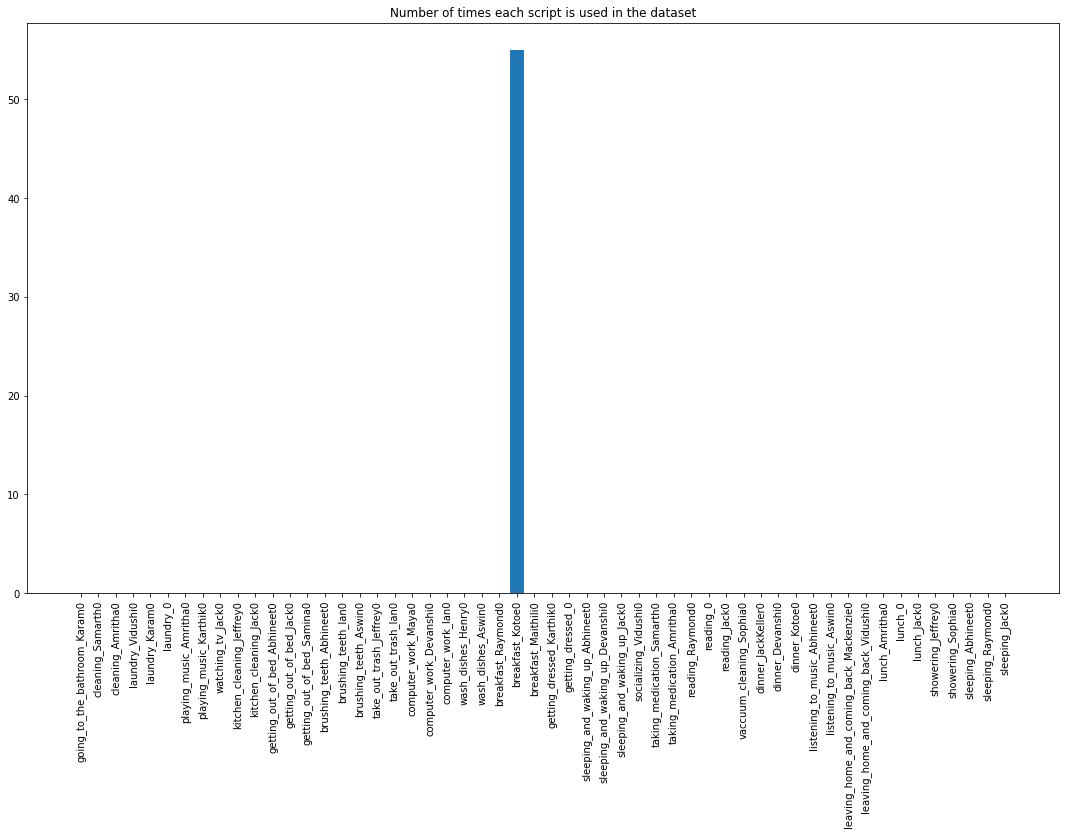

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.bar(scripts_used.keys(), scripts_used.values())
_ = plt.xticks(rotation=90)
_ = ax.set_title('Number of times each script is used in the dataset')

In [14]:


refercnce_full_graph = data_test[0]['graphs'][0]

## update utilized objects to include complete tree
check_ids = utilized_object_ids
while len(check_ids) > 0:
    next_check_ids = set()
    for e in refercnce_full_graph['edges']:
        if e['from_id'] in check_ids and e['relation_type'] in edge_classes:
            utilized_object_ids.add(e['to_id'])
            next_check_ids.add(e['to_id'])
    check_ids = next_check_ids

for data in data_train:
    data['graphs'] = remove_ignored_classes(data['graphs'])
with open(os.path.join(TEMP_DIR,'routines_train.json'), 'w') as f:
    json.dump(data_train, f)

for data in data_test:
    data['graphs'] = remove_ignored_classes(data['graphs'])
with open(os.path.join(TEMP_DIR,'routines_test.json'), 'w') as f:
    json.dump(data_test, f)

refercnce_graph = data_test[0]['graphs'][0]

In [15]:
nodes = refercnce_graph['nodes']
with open(os.path.join(TEMP_DIR,'classes.json'), 'w') as f:
    json.dump({"nodes":nodes, "edges":edge_classes}, f)

In [16]:
info['num_nodes'] = len(nodes)
search_objects = [n for n in nodes if n['id'] in utilized_object_ids and n['category']=='placable_objects']
info['search_object_ids'] = [n['id'] for n in search_objects]
info['search_object_names'] = [n['class_name'] for n in search_objects]
for k,v in info.items():
    print(k,' : ',v)
with open(os.path.join(TEMP_DIR,'info.json'), 'w') as f:
    json.dump(info, f)

dt  :  10
num_train_routines  :  50
num_test_routines  :  5
weekend_days  :  []
start_time  :  360
end_time  :  1440
interleaving  :  False
only_used_objects  :  True
graphs_dt_apart  :  False
max_activities_per_day  :  7
breakfast_only  :  True
single_script_only  :  True
num_nodes  :  17
search_object_ids  :  [1048, 1090, 1114, 1118, 1146, 1165, 1176]
search_object_names  :  ['coffee_filter', 'food_egg', 'fork', 'ground_coffee', 'mug', 'plate', 'sauce_pan']


In [17]:
DATASET_DIR = 'data/sourcedRoutines/differentBreakfasts0202'

if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)
shutil.move(TEMP_DIR, DATASET_DIR)


'data/sourcedRoutines/singleBreakfast0202'

In [18]:
DESTINATION_DIR = os.path.join('../../SpatioTemporalObjectTracking/data/',os.path.basename(DATASET_DIR))

if not os.path.exists(DESTINATION_DIR):
    shutil.copytree(DATASET_DIR, DESTINATION_DIR)
    print('Successfully copied to ',DESTINATION_DIR)
else:
    overwrite = input(DESTINATION_DIR+' already exists. Do you want to overwrite it? (y/n)')
    if overwrite:
        shutil.rmtree(DESTINATION_DIR)
        shutil.copytree(DATASET_DIR, DESTINATION_DIR)
        print('Successfully copied to ',DESTINATION_DIR)
    else:
        print('Skipping copy')

Successfully copied to  ../../SpatioTemporalObjectTracking/data/singleBreakfast0202
